# Exploration and preprocessing of data

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

data = pd.read_csv('data/cs_subs.csv').dropna().drop_duplicates()  # unzip this file
data.sample(10)

,title,score,subreddit
344423,Constantly getting this message that iCloud is...,1,Android
84875,I've not even had windows for a day and i am s...,1,linux
306775,Help with a useless machine,2,arduino
419835,Morgan Stanley,2,cscareerquestions
516169,pokemon or big data?,1,datascience
493568,Lens Blur Improvement Idea,34,Android
366419,Customized Shopping Cart Development Services ...,1,Web_Development
385774,Simulation for Hardware Startups - Making prot...,2,IOT
172135,Autodesk 2017 Product Keys Keygen Full Free Do...,1,softwaredevelopment
80775,Best Clone Websites &amp; Mobile Apps - All re...,1,Web_Development


#### Getting an overview of the data

In [10]:
def overview(data):
    print('Number of unique subreddits:', len(data['subreddit'].unique()))
    print('Total # of posts:', data.shape[0], '\n')

    title = 'Counts of posts by subreddit'
    order = data['subreddit'].value_counts().index
    plt.figure(figsize=(16,8))
    plt.title(title)
    sns.countplot(data['subreddit'], order=order)

    pd.options.display.max_rows = 20
    print(title)
    print(data['subreddit'].value_counts())

Number of unique subreddits: 136
Total # of posts: 615825 

Counts of posts by subreddit
Android              60169
learnprogramming     34834
cscareerquestions    32832
Windows10            27264
webdev               26273
softwaregore         23641
dataisbeautiful      23300
web_design           21165
ProgrammerHumor      19025
learnpython          17519
                     ...  
pythoncoding            87
vagrant                 77
Cprog                   38
androiddesign           36
osxterminal             31
learnlaravel            26
shell                   24
haskelltil              24
AskCompSci              17
dotfiles                16
Name: subreddit, Length: 136, dtype: int64


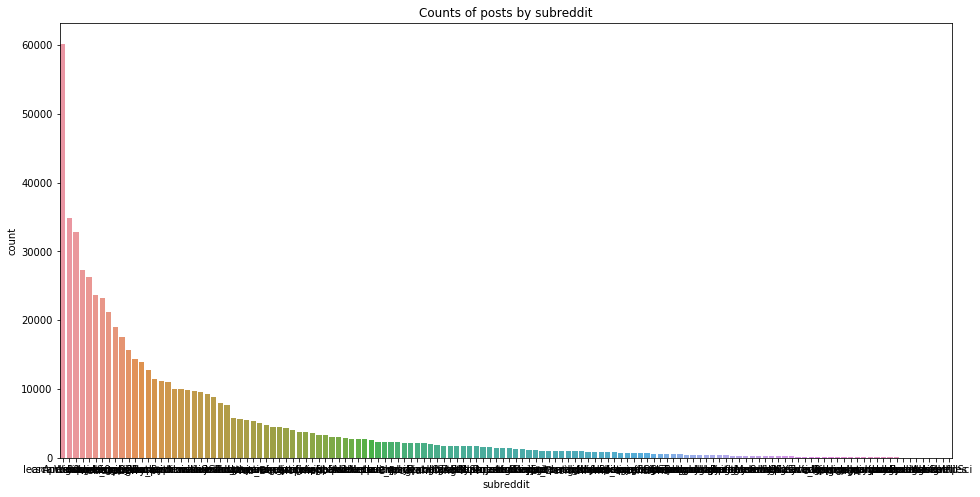

In [11]:
overview(data)

#### We are filtering subreddits that have less than 150 posts. 

Number of unique subreddits: 117
Total # of posts: 614464 

Counts of posts by subreddit
Android                60169
learnprogramming       34834
cscareerquestions      32832
Windows10              27264
webdev                 26273
softwaregore           23641
dataisbeautiful        23300
web_design             21165
ProgrammerHumor        19025
learnpython            17519
                       ...  
dartlang                 240
programmerreactions      237
Julia                    217
reviewmycode             216
zsh                      206
OSXTweaks                194
erlang                   186
d3js                     179
MaterialDesign           179
npm                      162
Name: subreddit, Length: 117, dtype: int64


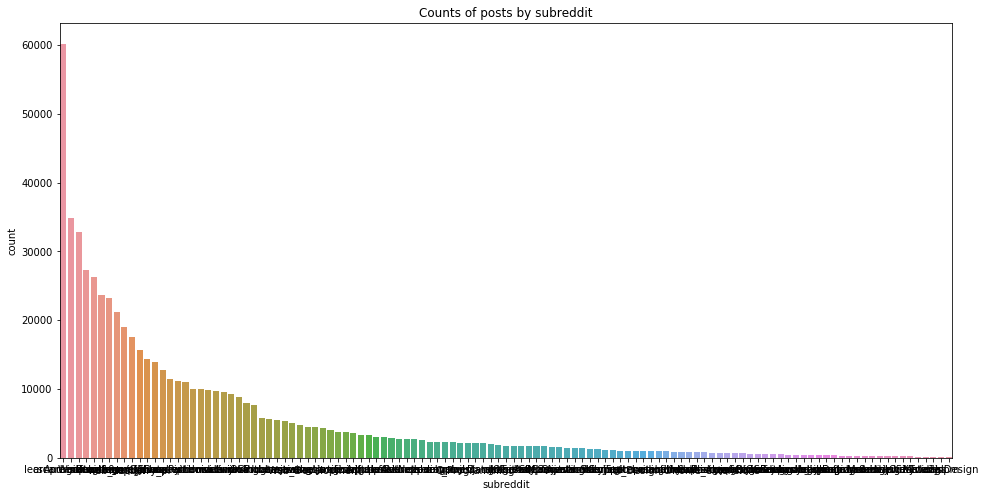

In [12]:
counts = data['subreddit'].value_counts()
counts = counts[counts > 150]
top_values = list(counts.index)
data = data[data['subreddit'].isin(top_values)]
overview(data)

That eliminated ~1300 posts and 19 classes. But we have still a lot of data, especially for my Macbook. Let's see the average reddit score (upvotes + downvotes) for each subreddit to filter out. I want to do mean and not median since median would just arbitrarily cut the data in half. Hopefully filtering by mean will take relatively larger chunks out of the more popular subreddits than the less popular ones.

Number of unique subreddits: 117
Total # of posts: 98268 

Counts of posts by subreddit
Android              6771
linuxquestions       3893
cscareerquestions    3772
learnpython          3060
webdev               2565
hackernews           2563
iOSBeta              2424
Windows10            2338
linux4noobs          2274
ProgrammerHumor      2182
                     ... 
Julia                  82
npm                    74
erlang                 72
zsh                    69
OSXTweaks              67
DatabaseHelp           59
MaterialDesign         51
d3js                   49
cprogramming           48
reviewmycode           44
Name: subreddit, Length: 117, dtype: int64


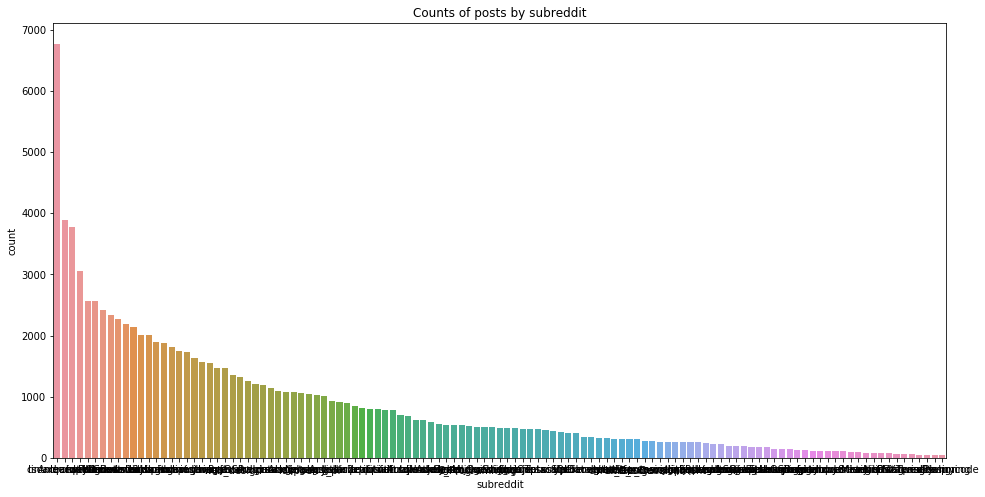

In [13]:
means = {}
for subreddit in data['subreddit'].unique():
    means[subreddit] = data[data['subreddit'] == subreddit]['score'].mean()
    
filtered = []
for subreddit in data['subreddit'].unique():
    filtered.append(data.loc[(data['subreddit'] == subreddit) & (data['score'] >= means[subreddit])])
    
filtered_data = pd.concat(filtered)
overview(filtered_data)

#### Cool! It seems a simple filter by mean brought up the tail end brought down (mostly!) the head, relatively speaking. For our purposes, I'm okay with that.

In [14]:
X = filtered_data['title']
y = filtered_data['subreddit']

#### Splitting data into train (60%), val (20%), and test (20%). The three part split is mostly for the neural network model since cross-validation is expensive for those.

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=17)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=31)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(58960,)
(19654,)
(19654,)
(58960,)
(19654,)
(19654,)


#### Encoding text labels to numerical ones e.g., Android -> 1, learnprogramming -> 2, etc.

In [33]:
label_encoder = LabelEncoder()
label_encoder.fit(data['subreddit'])

y_train = pd.Series(label_encoder.transform(y_train), name='subreddit', index=y_train.index)
y_val = pd.Series(label_encoder.transform(y_val), name='subreddit', index=y_val.index)
y_test = pd.Series(label_encoder.transform(y_test), name='subreddit', index=y_test.index)

#### Exporting data and encoder

In [34]:
pd.concat([X_train, y_train], axis=1).to_csv('data/cs_subs_train.csv', index=False)
pd.concat([X_val, y_val], axis=1).to_csv('data/cs_subs_val.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('data/cs_subs_test.csv', index=False)
pickle.dump(label_encoder, open('pickles/label_encoder.pkl', 'wb'))